In [1]:
import pandas as pd
import json
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau, chi2_contingency

In [2]:
eurozone_capitals = {
    "Paris": {
        "country": "France",
        "sw_lat": 48.815573, 
        "sw_long": 2.224199,
        "ne_lat": 48.902145, 
        "ne_long": 2.469920
    },
    "Berlin": {
        "country": "Germany",
        "sw_lat": 52.339784, 
        "sw_long": 13.088309,
        "ne_lat": 52.675454, 
        "ne_long": 13.761161
    },
    "Madrid": {
        "country": "Spain",
        "sw_lat": 40.312825, 
        "sw_long": -3.88912,
        "ne_lat": 40.643729, 
        "ne_long": -3.561463
    },
    "Rome": {
        "country": "Italy",
        "sw_lat": 41.799544, 
        "sw_long": 12.248678,
        "ne_lat": 42.020923, 
        "ne_long": 12.691870
    },
    "Amsterdam": {
        "country": "Netherlands",
        "sw_lat": 52.278174, 
        "sw_long": 4.728098,
        "ne_lat": 52.431157, 
        "ne_long": 5.079207
    },
    "Vienna": {
        "country": "Austria",
        "sw_lat": 48.166086, 
        "sw_long": 16.179051,
        "ne_lat": 48.323254, 
        "ne_long": 16.577574
    },
    "Lisbon": {
        "country": "Portugal",
        "sw_lat": 38.691399, 
        "sw_long": -9.229064,
        "ne_lat": 38.788765, 
        "ne_long": -9.092600
    },
    "Brussels": {
        "country": "Belgium",
        "sw_lat": 50.779517, 
        "sw_long": 4.243715,
        "ne_lat": 50.913706, 
        "ne_long": 4.469936
    },
    "Athens": {
        "country": "Greece",
        "sw_lat": 37.885082, 
        "sw_long": 23.599058,
        "ne_lat": 38.056439, 
        "ne_long": 23.818654
    },
    "Dublin": {
        "country": "Ireland",
        "sw_lat": 53.298439, 
        "sw_long": -6.387438,
        "ne_lat": 53.410082, 
        "ne_long": -6.114448
    }
}


# Import Data

In [3]:
df = pd.read_json('data/bnb/Lisbon.json')
bnbcol = df.columns

airbnb_df = pd.DataFrame(columns=bnbcol)
for city in eurozone_capitals.keys():
    with open(f'data/bnb/{city}.json', 'r') as f:
        df = pd.read_json(f)
        df['city'] = city
        airbnb_df = pd.concat([airbnb_df, df], ignore_index=True)

In [4]:
tlist = list()
for city in eurozone_capitals.keys():
    with open(f'data/cost/{city}.json', 'r') as f:
        row = json.load(f)
        tlist.append(row)
cost_df = pd.DataFrame(tlist)

# Clean Data

In [5]:
for i in range(len(airbnb_df)):   
    price = airbnb_df.iloc[i].price
    airbnb_df.at[i, 'price'] = price['total']['amount']

In [6]:
for i in range(len(airbnb_df)):
    total_fee = 0
    fee = airbnb_df.iloc[i].fee
    for key in fee.keys():
        total_fee += fee[key].get('amount', 0)
    airbnb_df.at[i, 'fee'] = total_fee

In [7]:
for i in range(len(airbnb_df)):
    rating = airbnb_df.iloc[i].rating
    airbnb_df.at[i, 'stars'] = rating['value']
    airbnb_df.at[i, 'review_count'] = rating['reviewCount']

In [8]:
for i in range(len(airbnb_df)):
    badges = airbnb_df.iloc[i].badges
    if len(badges) > 0:
        airbnb_df.at[i, 'badges'] = badges[0]
    else :
        airbnb_df.at[i, 'badges'] = 'None'

In [9]:
airbnb_df.drop('coordinates', axis=1, inplace=True)
airbnb_df.drop('long_stay_discount', axis=1, inplace=True)
airbnb_df.drop('kind', axis=1, inplace=True)
airbnb_df.drop('images', axis=1, inplace=True)
airbnb_df.drop('rating', axis=1, inplace=True)

In [10]:
airbnb_df.drop_duplicates(subset=['room_id'], inplace=True)

# EDA 

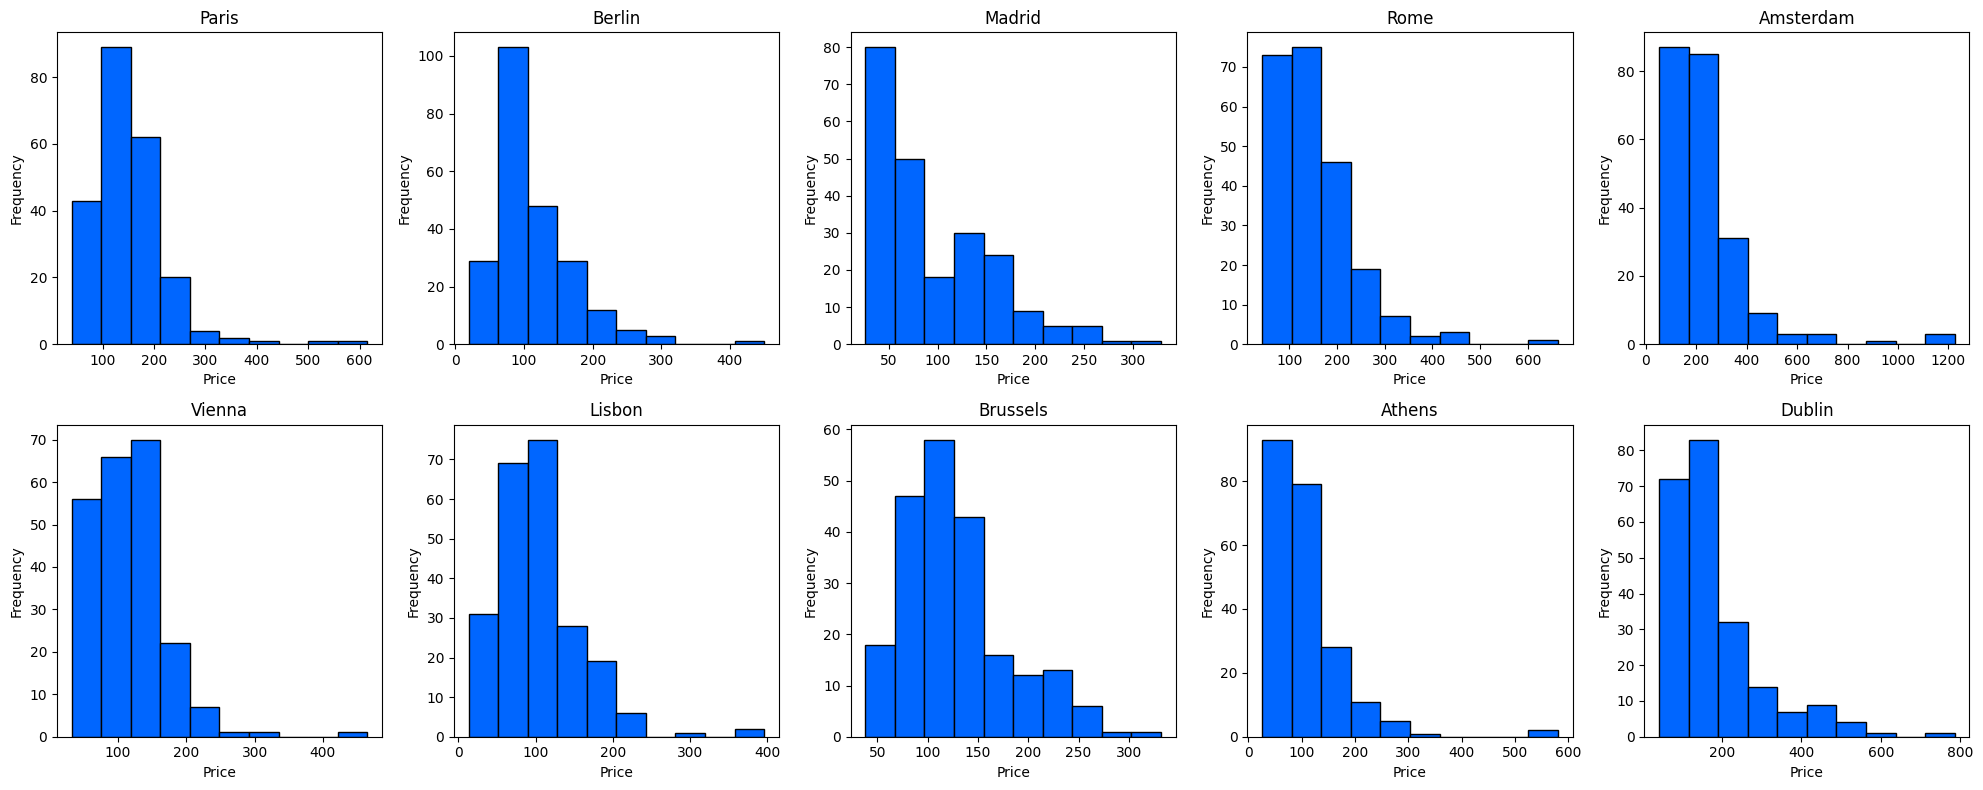

In [11]:
# Get unique cities
cities = airbnb_df['city'].unique()

color = '#0066FF'

# Define grid size
nrows, ncols = 2, 5  # 2 by 5 grid

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
axes = axes.flatten()  # Flatten the 2D array of axes so it can be indexed easily

# Plot histograms for each city
for i, city in enumerate(cities):
    city_data = airbnb_df[airbnb_df['city'] == city]['price']
    ax = axes[i]  # select the current subplot
    ax.hist(city_data, bins=10, color=color, edgecolor='black')
    ax.set_title(f'{city}')
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')

# Hide any unused subplots (if any)
for j in range(len(cities), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

<Axes: xlabel='city', ylabel='rent_onebed_center'>

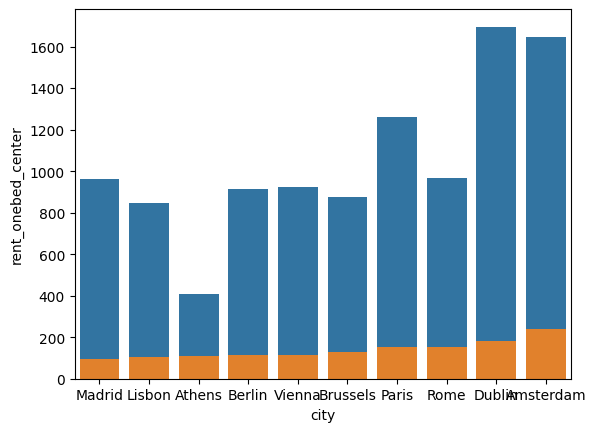

In [12]:
for city in cities:
    cost_df.loc[cost_df['city'] == city, 'avg_airbnb_price'] = airbnb_df[airbnb_df['city'] == city]['price'].mean()
    cost_df.loc[cost_df['city'] == city, 'median_airbnb_price'] = airbnb_df[airbnb_df['city'] == city]['price'].median()

cost_df.sort_values(by=['avg_airbnb_price'], inplace=True)

sns.barplot(data=cost_df, x='city', y='rent_onebed_center')
sns.barplot(data=cost_df, x='city', y='avg_airbnb_price')


<Axes: xlabel='avg_airbnb_price', ylabel='sqrtm_suburbs'>

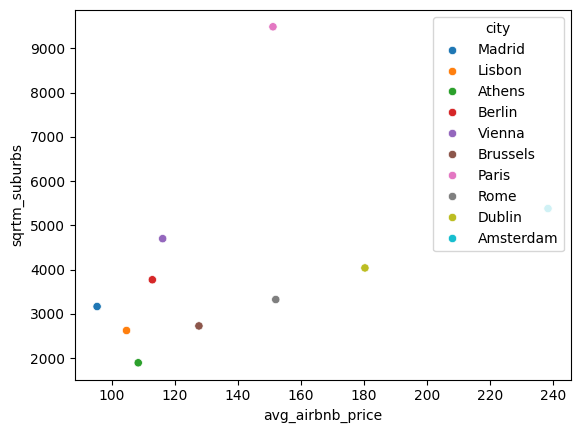

In [13]:
sns.scatterplot(data=cost_df, x='avg_airbnb_price', y='sqrtm_suburbs', hue='city')

In [14]:
print("Pearson's correlation coefficient between Average Airbnb Price and:")
for col in cost_df.columns:
    if cost_df[col].dtype != 'object' and col != 'avg_airbnb_price' and col != 'median_airbnb_price':
        pearson_corr, _ = pearsonr(cost_df['avg_airbnb_price'], cost_df[col])
        print(f"{col}: {pearson_corr:.2f}")

Pearson's correlation coefficient between Average Airbnb Price and:
sqrtm_suburbs: 0.41
sqrtm_center: 0.40
beer: 0.42
rent_onebed_suburbs: 0.83
rent_onebed_center: 0.83
rent_threebed_suburbs: 0.80
rent_threebed_center: 0.75
mcmeal: 0.50
salary_after_tax: 0.63
utilities: 0.18


In [15]:
print("Spearman's correlation coefficient between Average Airbnb Price and:")
for col in cost_df.columns:
    if cost_df[col].dtype != 'object' and col != 'avg_airbnb_price' and col != 'median_airbnb_price':
        spearman_corr, _ = spearmanr(cost_df['avg_airbnb_price'], cost_df[col])
        print(f"{col}: {spearman_corr:.2f}")

Spearman's correlation coefficient between Average Airbnb Price and:
sqrtm_suburbs: 0.65
sqrtm_center: 0.52
beer: 0.52
rent_onebed_suburbs: 0.50
rent_onebed_center: 0.75
rent_threebed_suburbs: 0.89
rent_threebed_center: 0.68
mcmeal: 0.64
salary_after_tax: 0.73
utilities: 0.39


In [16]:
print("Kendall Tau's correlation coefficient between Average Airbnb Price and:")
for col in cost_df.columns:
    if cost_df[col].dtype != 'object' and col != 'avg_airbnb_price' and col != 'median_airbnb_price':
        kendall_corr, _ = kendalltau(cost_df['avg_airbnb_price'], cost_df[col])
        print(f"{col}: {kendall_corr:.2f}")

Kendall Tau's correlation coefficient between Average Airbnb Price and:
sqrtm_suburbs: 0.47
sqrtm_center: 0.33
beer: 0.38
rent_onebed_suburbs: 0.38
rent_onebed_center: 0.56
rent_threebed_suburbs: 0.69
rent_threebed_center: 0.47
mcmeal: 0.44
salary_after_tax: 0.60
utilities: 0.24


In [17]:
master_df = pd.merge(cost_df, airbnb_df, how='right', on='city')
master_df

,city,country,sqrtm_suburbs,sqrtm_center,beer,rent_onebed_suburbs,rent_onebed_center,rent_threebed_suburbs,rent_threebed_center,mcmeal,...,room_id,category,name,title,type,fee,price,badges,stars,review_count
0,Paris,France,9488.27,12643.57,2.14,903.76,1260.61,1824.76,2845.90,9.29,...,43969632,private_room,Bedroom in the middle of Paris,Room in Paris,REGULAR,10.0,80.0,None,4.60,539
1,Paris,France,9488.27,12643.57,2.14,903.76,1260.61,1824.76,2845.90,9.29,...,1149165138143029561,private_room,Room & Bathroom A/C Breakfast - Eiffel Tower view,Room in Puteaux,REGULAR,22.0,94.0,GUEST_FAVORITE,5.00,39
2,Paris,France,9488.27,12643.57,2.14,903.76,1260.61,1824.76,2845.90,9.29,...,1007809801050591084,entire_home,Beau studio-Top stay in Paris-Métro RER Vincennes,Condo in Fontenay-sous-Bois,REGULAR,10.0,75.0,GUEST_FAVORITE,4.91,96
3,Paris,France,9488.27,12643.57,2.14,903.76,1260.61,1824.76,2845.90,9.29,...,1163611190566724661,entire_home,Studio cosy à Paris,Apartment in Paris,REGULAR,15.0,114.0,GUEST_FAVORITE,4.93,67
4,Paris,France,9488.27,12643.57,2.14,903.76,1260.61,1824.76,2845.90,9.29,...,1001033107665810259,private_room,Chambre privée avenue Trudaine,Room in Paris,REGULAR,15.0,114.0,GUEST_FAVORITE,5.00,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,Dublin,Ireland,4037.82,5833.38,2.62,1409.68,1695.68,2432.04,3184.05,9.19,...,20831067,private_room,Apartment near Dublin Airport,Room in Dublin,REGULAR,22.0,147.0,None,4.40,5
2232,Dublin,Ireland,4037.82,5833.38,2.62,1409.68,1695.68,2432.04,3184.05,9.19,...,1105781404363123969,private_room,Welcome to Portobello house,Room in Dublin,REGULAR,28.0,188.0,None,0.00,0
2233,Dublin,Ireland,4037.82,5833.38,2.62,1409.68,1695.68,2432.04,3184.05,9.19,...,1177659688058916684,private_room,Central Comfort for Concerts,Room in Dublin,REGULAR,51.0,246.0,None,0.00,0
2234,Dublin,Ireland,4037.82,5833.38,2.62,1409.68,1695.68,2432.04,3184.05,9.19,...,879884258608501582,private_room,Dublin City Centre Accommodation,Room in Dublin,REGULAR,14.0,93.0,None,0.00,0


In [18]:
print("Pearson's correlation coefficient between Average Airbnb Price and:")
for col in cost_df.columns:
    if cost_df[col].dtype != 'object' and col != 'avg_airbnb_price' and col != 'median_airbnb_price':
        pearson_corr, _ = pearsonr((master_df['price'].astype(float)), master_df[col].astype(float))
        print(f"{col}: {pearson_corr:.2f}")
        
print("Spearman's correlation coefficient between Average Airbnb Price and:")
for col in cost_df.columns:
    if cost_df[col].dtype != 'object' and col != 'avg_airbnb_price' and col != 'median_airbnb_price':
        spearman_corr, _ = spearmanr(cost_df['avg_airbnb_price'], cost_df[col])
        print(f"{col}: {spearman_corr:.2f}")
        
print("Kendall Tau's correlation coefficient between Average Airbnb Price and:")
for col in cost_df.columns:
    if cost_df[col].dtype != 'object' and col != 'avg_airbnb_price' and col != 'median_airbnb_price':
        kendall_corr, _ = kendalltau(cost_df['avg_airbnb_price'], cost_df[col])
        print(f"{col}: {kendall_corr:.2f}")

Pearson's correlation coefficient between Average Airbnb Price and:
sqrtm_suburbs: 0.18
sqrtm_center: 0.17
beer: 0.18
rent_onebed_suburbs: 0.36
rent_onebed_center: 0.36
rent_threebed_suburbs: 0.35
rent_threebed_center: 0.33
mcmeal: 0.22
salary_after_tax: 0.27
utilities: 0.08
Spearman's correlation coefficient between Average Airbnb Price and:
sqrtm_suburbs: 0.65
sqrtm_center: 0.52
beer: 0.52
rent_onebed_suburbs: 0.50
rent_onebed_center: 0.75
rent_threebed_suburbs: 0.89
rent_threebed_center: 0.68
mcmeal: 0.64
salary_after_tax: 0.73
utilities: 0.39
Kendall Tau's correlation coefficient between Average Airbnb Price and:
sqrtm_suburbs: 0.47
sqrtm_center: 0.33
beer: 0.38
rent_onebed_suburbs: 0.38
rent_onebed_center: 0.56
rent_threebed_suburbs: 0.69
rent_threebed_center: 0.47
mcmeal: 0.44
salary_after_tax: 0.60
utilities: 0.24


In [19]:
def remove_outliers(df,col):

  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)

  # Compute IQR
  IQR = Q3 - Q1

  # Define bounds
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Filter the dataframe
  return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


In [20]:
master_df = remove_outliers(master_df, 'price')

In [21]:
print("Pearson's correlation coefficient between Average Airbnb Price and:")
for col in cost_df.columns:
    if cost_df[col].dtype != 'object' and col != 'avg_airbnb_price' and col != 'median_airbnb_price':
        pearson_corr, _ = pearsonr((master_df['price'].astype(float)), master_df[col].astype(float))
        print(f"{col}: {pearson_corr:.2f}")
        
print("Spearman's correlation coefficient between Average Airbnb Price and:")
for col in cost_df.columns:
    if cost_df[col].dtype != 'object' and col != 'avg_airbnb_price' and col != 'median_airbnb_price':
        spearman_corr, _ = spearmanr(cost_df['avg_airbnb_price'], cost_df[col])
        print(f"{col}: {spearman_corr:.2f}")
        
print("Kendall Tau's correlation coefficient between Average Airbnb Price and:")
for col in cost_df.columns:
    if cost_df[col].dtype != 'object' and col != 'avg_airbnb_price' and col != 'median_airbnb_price':
        kendall_corr, _ = kendalltau(cost_df['avg_airbnb_price'], cost_df[col])
        print(f"{col}: {kendall_corr:.2f}")

Pearson's correlation coefficient between Average Airbnb Price and:
sqrtm_suburbs: 0.22
sqrtm_center: 0.21
beer: 0.19
rent_onebed_suburbs: 0.31
rent_onebed_center: 0.32
rent_threebed_suburbs: 0.31
rent_threebed_center: 0.31
mcmeal: 0.25
salary_after_tax: 0.27
utilities: 0.10
Spearman's correlation coefficient between Average Airbnb Price and:
sqrtm_suburbs: 0.65
sqrtm_center: 0.52
beer: 0.52
rent_onebed_suburbs: 0.50
rent_onebed_center: 0.75
rent_threebed_suburbs: 0.89
rent_threebed_center: 0.68
mcmeal: 0.64
salary_after_tax: 0.73
utilities: 0.39
Kendall Tau's correlation coefficient between Average Airbnb Price and:
sqrtm_suburbs: 0.47
sqrtm_center: 0.33
beer: 0.38
rent_onebed_suburbs: 0.38
rent_onebed_center: 0.56
rent_threebed_suburbs: 0.69
rent_threebed_center: 0.47
mcmeal: 0.44
salary_after_tax: 0.60
utilities: 0.24


In [22]:
mean_values = cost_df.mean(numeric_only=True)

cost_df = pd.concat([cost_df, mean_values.to_frame().T], ignore_index=True)
cost_df.fillna("Average", inplace=True)
cost_df

,city,country,sqrtm_suburbs,sqrtm_center,beer,rent_onebed_suburbs,rent_onebed_center,rent_threebed_suburbs,rent_threebed_center,mcmeal,salary_after_tax,utilities,avg_airbnb_price,median_airbnb_price
0,Madrid,Spain,3165.610,5413.680,1.050,715.320,962.600,1184.520,1735.000,8.250,1604.330,141.160,95.390135,70.0
1,Lisbon,Portugal,2623.480,4453.120,1.100,665.350,845.720,1078.860,1618.240,6.700,1070.690,115.900,104.727273,96.0
2,Athens,Greece,1894.030,1868.720,1.400,352.360,410.010,651.900,734.610,6.190,843.610,143.330,108.438356,86.0
3,Berlin,Germany,3770.820,6098.770,0.970,676.490,912.660,1242.870,1759.440,8.250,2474.760,223.040,112.917391,100.0
4,Vienna,Austria,4699.590,7927.100,1.000,659.070,921.400,1231.440,1680.320,8.250,2406.400,208.160,116.183036,114.5
5,Brussels,Belgium,2727.020,3498.250,1.590,712.220,875.530,1301.780,1558.560,9.290,2560.010,129.940,127.688372,117.0
6,Paris,France,9488.270,12643.570,2.140,903.760,1260.610,1824.760,2845.900,9.290,2633.860,167.830,151.165919,137.0
7,Rome,Italy,3323.820,7101.900,1.290,660.160,967.950,1243.920,2047.840,8.250,1507.820,185.550,152.053097,127.0
8,Dublin,Ireland,4037.820,5833.380,2.620,1409.680,1695.680,2432.040,3184.050,9.190,2667.540,157.180,180.336323,147.0
9,Amsterdam,Netherlands,5380.000,7837.980,1.270,1324.840,1643.800,2075.690,2757.500,8.770,3014.660,176.660,238.396396,194.5


In [23]:
import datautils as du

df = du.get_avg_correlation_metrics()
df

,category,pearson,spearman,kendall
0,sqrtm_suburbs,0.412667,0.648485,0.466667
1,sqrtm_center,0.395618,0.515152,0.333333
2,beer,0.416785,0.515152,0.377778
3,rent_onebed_suburbs,0.832102,0.50303,0.377778
4,rent_onebed_center,0.82762,0.745455,0.555556
5,rent_threebed_suburbs,0.797722,0.890909,0.688889
6,rent_threebed_center,0.749187,0.684848,0.466667
7,mcmeal,0.50058,0.639879,0.435286
8,salary_after_tax,0.627348,0.733333,0.6
9,utilities,0.179581,0.393939,0.244444
